# Playground

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
from diffusers import AutoencoderKL, StableDiffusionXLPipeline
from transformers import AutoTokenizer
MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"
device = "cuda" if torch.cuda.is_available() else "cpu"
weight_dtype = torch.float16
rank=64
%load_ext autoreload
%autoreload 2

from unziplora_unet import utils


/home/changl25/miniconda3/envs/unziplora/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/changl25/miniconda3/envs/unziplora/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
from train_unziplora import import_model_class_from_model_name_or_path

tokenizer_one = AutoTokenizer.from_pretrained(
    MODEL_ID,
    subfolder="tokenizer",
    use_fast=False,
)
tokenizer_two = AutoTokenizer.from_pretrained(
    MODEL_ID,
    subfolder="tokenizer_2",
    use_fast=False,
)
text_encoder_cls_one = import_model_class_from_model_name_or_path(
    MODEL_ID, revision=None
)
text_encoder_cls_two = import_model_class_from_model_name_or_path(
    MODEL_ID, subfolder="text_encoder_2", revision=None
)
text_encoder_one = text_encoder_cls_one.from_pretrained(
    MODEL_ID, subfolder="text_encoder",
)
text_encoder_two = text_encoder_cls_two.from_pretrained(
    MODEL_ID, subfolder="text_encoder_2",
)
text_encoder_one.requires_grad_(False)
text_encoder_one.to(device, dtype=torch.float16)

text_encoder_two.requires_grad_(False)
text_encoder_two.to(device, dtype=torch.float16)
tokenizers = [tokenizer_one, tokenizer_two]
text_encoders = [text_encoder_one, text_encoder_two]

vae = AutoencoderKL.from_pretrained(
            MODEL_ID,
            subfolder="vae",
            revision=None
    )

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
/home/changl25/miniconda3/envs/unziplora/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
def log_validation(pipeline, prompt, prompt_content, prompt_style, seed=0):
    generator = torch.Generator(device=device).manual_seed(seed)
    # Currently the context determination is a bit hand-wavy. We can improve it in the future if there's a better
    # way to condition it. Reference: https://github.com/huggingface/diffusers/pull/7126#issuecomment-1968523051
    if pipeline.__class__.__name__ == 'StableDiffusionXLUnZipLoRAPipeline':
        pipeline_args = {"prompt": prompt, 
                        "prompt_content": prompt_content, 
                        "prompt_style": prompt_style}
    else: 
        pipeline_args = {"prompt": prompt}
    print(pipeline_args)    
    images = [pipeline(**pipeline_args, generator=generator, num_inference_steps=50).images[0] for _ in range(4)]
    return images

In [5]:
def show_img(images):
    np_images = np.hstack([np.asarray(img) for img in images])
    plt.figure(figsize=(10,10))
    plt.imshow(np_images)
    plt.axis("off")
    plt.show()

In [6]:
def show_single_img(image):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [7]:
def load_pipeline_unet(output_dir, output_dir2):
    content_unet_path = f"{output_dir}_content"
    style_unet_path = f"{output_dir2}_style"
    weight_content_path=f"{output_dir}_merger_content.pth"
    weight_style_path=f"{output_dir2}_merger_style.pth"
    pipeline = utils.load_pipeline_from_sdxl(
        MODEL_ID, vae = vae
    )
    pipeline.unet = utils.insert_unziplora_to_unet(pipeline.unet,
        content_unet_path, 
        style_unet_path, 
        weight_content_path,
        weight_style_path,      
        rank=64)
    pipeline = pipeline.to(device, dtype=weight_dtype)
    
    return pipeline

In [8]:
def remove_pipeline(pipeline):
    del pipeline
    torch.cuda.empty_cache()

## Content / Style Individual Generation

In [9]:
content = "rose"
style = "pop art"

### Use Pipeline

In [ ]:
model_dir = "models/pop_art_rose/pop_art_rose"

/home/changl25/miniconda3/envs/unziplora/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/changl25/miniconda3/envs/unziplora/lib/python3.11/site-packages/diffusers/loaders/lora.py:407: FutureWarning: `unet.unet keys` is deprecated and will be removed in version 0.27. Keys starting with 'unet.unet' are deprecated.
  deprecate("unet.unet keys", "0.27", deprecation_message)


{'prompt': 'A photo of monadikos rose'}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

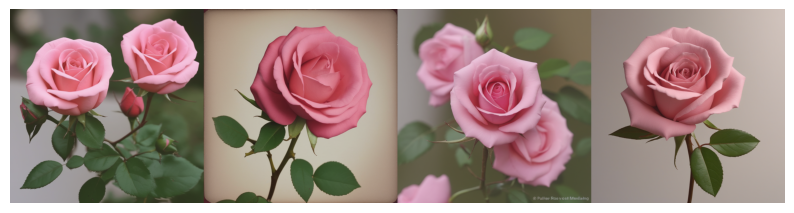

In [15]:
pipeline = StableDiffusionXLPipeline.from_pretrained(
    MODEL_ID,
    vae=vae,
    torch_dtype=weight_dtype,
)
pipeline.load_lora_weights(f"{model_dir}_content")
pipeline.to(device, dtype=weight_dtype)
prompt_content_main = f"A photo of monadikos {content}"
prompt_content = f"A photo of monadikos {content}"
imgs_content = log_validation(pipeline, prompt_content, prompt_content, prompt_content)
show_img(imgs_content)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'prompt': 'a dog in pop art style'}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

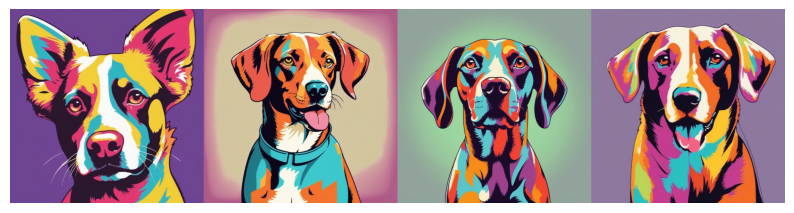

In [20]:
pipeline = StableDiffusionXLPipeline.from_pretrained(
    MODEL_ID,
    vae=vae,
    torch_dtype=weight_dtype,
)
pipeline.load_lora_weights(f"{model_dir}_style")
pipeline.to(device, dtype=weight_dtype)
prompt_style = f"a dog in {style} style"

imgs_style = log_validation(pipeline, prompt_style, prompt_style, prompt_style)
show_img(imgs_style)

### Use UnZipLoRA Pipeline

## Combine Generation

In [ ]:
model_dir_content = "models/pop_art_rose/pop_art_rose"
model_dir_style = "models/pop_art_rose/pop_art_rose"
pipeline = load_pipeline_unet(model_dir_content, model_dir_style)

{'prompt': 'a monadikos rose in pop art style on a skateboard', 'prompt_content': 'a monadikos rose on a skateboard', 'prompt_style': 'a rose in pop art style on a skateboard'}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

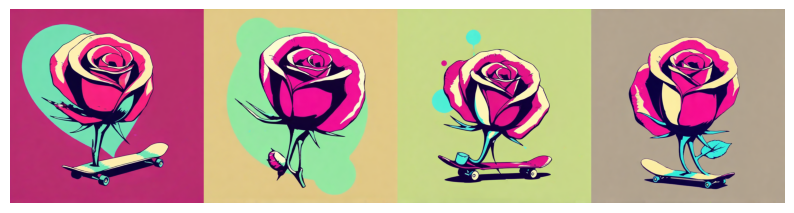

In [27]:
prompt_combine = f"a monadikos {content} in {style} style on a skateboard"
prompt_combine_content = f"a monadikos {content} on a skateboard"
prompt_combine_style = f"a {content} in {style} style on a skateboard"

pipeline.unet = utils.unziplora_set_forward_type(pipeline.unet, type="both")
imgs = log_validation(pipeline, prompt_combine, prompt_combine_content, prompt_combine_style)
show_img(imgs)

## Cross-image Generation

In [28]:
model_dir_content = "models/pop_art_rose/pop_art_rose"
model_dir_style = "models/geometric_microscope/geometric_microscoperose"
content_prompt = "rose"
style_prompt = "geometry shapes"

In [29]:
pipeline = load_pipeline_unet(model_dir_content, model_dir_style)

{'prompt': 'a monadikos rose in geometry shapes style', 'prompt_content': 'a monadikos rose ', 'prompt_style': 'a rose in geometry shapes style'}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

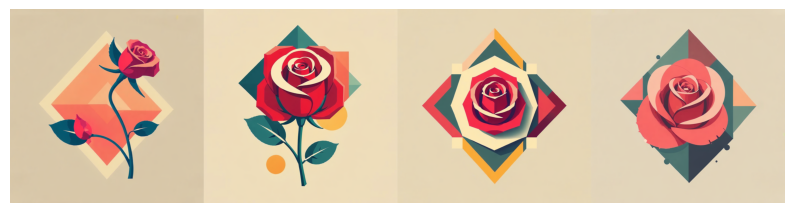

In [30]:
prompt_combine = f"a monadikos {content_prompt} in {style_prompt} style"
prompt_combine_content = f"a monadikos {content_prompt} "
prompt_combine_style = f"a {content_prompt} in {style_prompt} style"

pipeline.unet = utils.unziplora_set_forward_type(pipeline.unet, type="both")
imgs = log_validation(pipeline, prompt_combine, prompt_combine_content, prompt_combine_style)
show_img(imgs)